# Author: Michael Elgin (melgin@uwyo.edu)
# 2023_11_22

# Notebook for Pipeline Optimization

## Pipeline overview

This notebook explores the following ML pipeline components:

- Feature normalization
- Feature reduction (dimensionality reduction)
- Sample reduction

Changes to these pipeline components are examined for their affect on regression and classification.

For regression, a linear model is used. (white wine only)

For classification, a decision tree is used.

### Feature normalization overview

Feature normalization, in this case, means to scale the features to their z-scores (or not).

### Feature reduction overview

Feature reduction will select the top 5 features that are most strongly positively/negatively correlated with the target (or not), discarding others.

### Sample reduction overview

Sample reduction, in this case, will be the decision of whether or not to remove outliers.

These are values that are outside the range of [Q1 - factor * IQR, Q3 + factor * IQR].

In [1]:
#Modules

#Python 3.11.2
import numpy as np #1.26.0
import pandas as pd #1.5.3
from sklearn.model_selection import GridSearchCV
from scipy import stats
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

import matplotlib.pyplot as plt #3.7.0

In [32]:
#All regression algorithms will use the white wine dataset.
#Classification will use both colors.
df_red = pd.read_csv("data/winequality-red.csv", sep=";")
df_white = pd.read_csv("data/winequality-white.csv", sep=";")

features_red = df_red.iloc[:, :-1]
features_white = df_white.iloc[:, :-1]
target_red = df_red['quality']
target_white = df_white['quality']

df_red_no_qual = df_red.drop("quality", axis=1)
df_white_no_qual = df_white.drop("quality", axis=1)
df_red_no_qual["color"] = 0
df_white_no_qual["color"] = 1
df_all = pd.concat([df_white_no_qual, df_red_no_qual], ignore_index=True)
features_all = df_all.iloc[:, :-1]
target_all = df_all['color']

#### Exploration of feature normalization - first see the effect of normalization on the data.


In [30]:
#Normalize the data
def pipe_normalize(df):
    """Will return a dataframe where columns have been zscored"""
    df_new = df.copy(deep=True)
    for column in df_new.columns:
        df_new[column] = stats.zscore(df_new[column])
    return df_new

In [27]:
features_white.describe() #Before

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


In [26]:
features_white_norm = pipe_normalize(features_white)
features_white_norm.describe() #After

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03,4.898000e+03
mean,-3.481630e-16,4.497106e-16,1.160543e-17,-1.066249e-16,3.133467e-16,-1.015476e-17,-4.642174e-17,3.247201e-14,-1.183754e-15,-8.218098e-16,-3.713739e-16
std,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00,1.000102e+00
min,-3.620351e+00,-1.966985e+00,-2.761743e+00,-1.141944e+00,-1.683274e+00,-1.958677e+00,-3.044230e+00,-2.313038e+00,-3.101408e+00,-2.364709e+00,-2.043297e+00
25%,-6.575011e-01,-6.771010e-01,-5.304757e-01,-9.250474e-01,-4.473347e-01,-7.237750e-01,-7.144739e-01,-7.707066e-01,-6.508363e-01,-6.997104e-01,-8.242757e-01
50%,-6.493106e-02,-1.809917e-01,-1.172780e-01,-2.349217e-01,-1.269060e-01,-7.692173e-02,-1.026189e-01,-9.609320e-02,-5.475133e-02,-1.739212e-01,-9.286267e-02
75%,5.276390e-01,4.143393e-01,4.611988e-01,6.918185e-01,1.935226e-01,6.287364e-01,6.739664e-01,6.930457e-01,6.075653e-01,5.271310e-01,7.198184e-01
max,8.705106e+00,8.153643e+00,1.095642e+01,1.171411e+01,1.374308e+01,1.491831e+01,7.098444e+00,1.503130e+01,4.184075e+00,5.171602e+00,2.995326e+00


In [29]:
features_all.describe() #Before

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


In [28]:
features_all_norm = pipe_normalize(features_all)
features_all_norm.describe() #After

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6497.000000,6.497000e+03,6497.000000,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03
mean,2.624754e-16,-2.449770e-16,3.499672e-17,6.999344e-17,0.000000,-8.749179e-17,0.000000,-3.560916e-15,2.738493e-15,2.099803e-16,-1.994813e-15
std,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077,1.000077e+00,1.000077,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00
min,-2.634589e+00,-1.577330e+00,-2.192833e+00,-1.018034e+00,-1.342639,-1.663583e+00,-1.941780,-2.530192e+00,-3.100615e+00,-2.091935e+00,-2.089350e+00
25%,-6.289329e-01,-6.661613e-01,-4.723335e-01,-7.657978e-01,-0.514799,-7.620742e-01,-0.685532,-7.859527e-01,-6.748622e-01,-6.805919e-01,-8.316152e-01
50%,-1.660892e-01,-3.016939e-01,-5.941375e-02,-5.135612e-01,-0.257883,-8.594301e-02,0.039907,6.448888e-02,-5.287424e-02,-1.429373e-01,-1.608231e-01
75%,3.738951e-01,3.664962e-01,4.911459e-01,5.584445e-01,0.255949,5.901882e-01,0.712265,7.648525e-01,6.313125e-01,4.619241e-01,6.776670e-01
max,6.699425e+00,7.534354e+00,9.231281e+00,1.268682e+01,15.842187,1.456357e+01,5.737257,1.476879e+01,4.923029e+00,9.870879e+00,3.696231e+00


#### Exploration of feature reduction

In [78]:
#Function to reduce the amount of features
def pipe_feature_reduce(df, target_name:str, amt=5):
    """Will return a dataframe with top <amt> of features based on correlation with target. Does not keep target"""
    corr = df.corr()
    corr = corr.drop([column for column in corr.columns if column != target_name], axis=1)
    corr = corr.drop(target_name, axis=0)
    corr[target_name] = abs(corr[target_name])
    features_with_corr = [i for i in zip(corr.index, [val for val in corr[target_name]])]
    features_with_corr_sorted = sorted(features_with_corr, key=lambda x: x[1], reverse=True)
    df_new = df.copy(deep=True)
    df_new = df_new.drop(target_name, axis=1)
    return df_new.drop([pair[0] for pair in features_with_corr_sorted[amt:]], axis=1)

In [79]:
#See dataframes after feature reduction
features_white_feature_reduce = pipe_feature_reduce(df_white, "quality", amt=5)
features_white_feature_reduce.describe()

,volatile acidity,chlorides,total sulfur dioxide,density,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,0.278241,0.045772,138.360657,0.994027,10.514267
std,0.100795,0.021848,42.498065,0.002991,1.230621
min,0.080000,0.009000,9.000000,0.987110,8.000000
25%,0.210000,0.036000,108.000000,0.991723,9.500000
50%,0.260000,0.043000,134.000000,0.993740,10.400000
75%,0.320000,0.050000,167.000000,0.996100,11.400000
max,1.100000,0.346000,440.000000,1.038980,14.200000


In [81]:
#See dataframes after feature reduction
features_all_feature_reduce = pipe_feature_reduce(df_all, "color", amt=5)
features_all_feature_reduce.describe()

,fixed acidity,volatile acidity,chlorides,total sulfur dioxide,sulphates
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.056034,115.744574,0.531268
std,1.296434,0.164636,0.035034,56.521855,0.148806
min,3.800000,0.080000,0.009000,6.000000,0.220000
25%,6.400000,0.230000,0.038000,77.000000,0.430000
50%,7.000000,0.290000,0.047000,118.000000,0.510000
75%,7.700000,0.400000,0.065000,156.000000,0.600000
max,15.900000,1.580000,0.611000,440.000000,2.000000


#### Exploration of sample reduction

In [99]:
#Function to return a dataframe with outliers removed
def pipe_sample_reduce(df, factor=1.5):
    """
    returns a new dataframe that has any samples removed where any value in the sample was
    outside the range of [Q1 - factor * IQR, Q3 + factor * IQR]"""
    df_new = df.copy(deep=True)
    Q1 = df_new.quantile(0.25)
    Q3 = df_new.quantile(0.75)
    IQR = Q3 - Q1
    return df_new[~((df_new < (Q1 - factor * IQR)) | (df_new > (Q3 + factor * IQR))).any(axis=1)]

In [100]:
#See difference in length of new dataframe to see how many outliers were removed
print(len(df_all))
print(len(pipe_sample_reduce(df_all, factor=1.5)))

6497
4336


In [101]:
#See difference in length of new dataframe to see how many outliers were removed
print(len(df_white))
print(len(pipe_sample_reduce(df_white, factor=1.5)))

4898
3858


# ----------------------------------

In [4]:
#Check to ensure target changing process has been done correctly
target_white.describe() #Should have values above 0 and 1

count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

In [5]:
target_all.describe() #Should have values as 0 and 1 only

count    6497.000000
mean        0.753886
std         0.430779
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: quality, dtype: float64

In [6]:
#Create decoder for hyperparam values between variable names and human-readable (mostly for graphs)
hp_decoder = {
    "max_depth": "Max Depth",
    "min_samples_split": "Min Samples for Split",
    "n_estimators" :    "Number of Trees",
    "C" : "C",
    "kernel" : "Kernel Type",
    "penalty" : "Penalty Type",
    "n_neighbors" : "Number of Neighbors",
    "metric" : "Distance Metric",
}

In [7]:
#Function to create graphs of average hyperparameter performance and also display best config

def evaluate(GS,
            hyperparam_data,
            performances,
            model_type,
            is_regression,
            ):
    """
    GS is the (already fitted) gridsearch object
    hyperparam_data is a list whose items are the associated data for each hyperparam:
        Each item is a list containing the following items:
            0. hyperparam list - the actual hyperparameter values used
            1. hyperparam exponents - the exponents used to create item 0 hyperparams as 2**x
                (or None for categorical hyperparams)
            2. the cross validation results from GS for that hyperparam
            3. the readable name for the hyperparam
    performances is the GS.cv_results_
    model_type is a string for the folder to place the graph(s) in and also prefix the file names with
    is_regression is a bool for whether this is regression or classification
    """
    #Now to loop thru, for every candidate find which runs it was a part of, and take the average of those performances

    file_path = "graphs/" + model_type + "/"

    param_evals = {}

    for hyperparam_list, exponents, cv_results, name in hyperparam_data:
        avgs = []
        for candidate in hyperparam_list:
            indexes = np.where(cv_results == candidate)[0]
            hyperparam_performances = [performances[index] for index in indexes]
            avg = sum(hyperparam_performances)/len(hyperparam_performances)
            avgs.append(avg)

        param_evals[name] = avgs

        plt.figure(figsize=(10,10))
        if exponents != None:
            plt.plot(exponents, avgs)
            plt.xticks(exponents)
            plt.grid(True)
        else: #categorical hyperparam
            plt.bar(hyperparam_list, avgs)
            plt.tight_layout()
        plt.title("Effect of varying " + hp_decoder[name])
        plt.xlabel(name if exponents == None else "$log_2$(" + hp_decoder[name] + ")")
        plt.ylabel("Negative Loss" if is_regression else "Accuracy")
        plt.tight_layout()
        plt.savefig(file_path + model_type + "_" + name)

    print("Best hyperparams overall:")
    print(GS.best_params_)
    print("Best score with those hyperparams:")
    print(GS.best_score_)

    return param_evals

In [8]:
#Model 1 - Decision Tree

from sklearn.tree import DecisionTreeRegressor

#Hyperparams - exponential grid-search
hp_list_max_depth_exponents_DTR = [i for i in range(0,7)]
hp_list_max_depth_DTR = [2**i for i in hp_list_max_depth_exponents_DTR]

hp_list_min_samples_split_exponents_DTR = [i for i in range(1, 15)]
hp_list_min_samples_split_DTR = [2**i for i in hp_list_min_samples_split_exponents_DTR]

params_inputs_DTR = {
    'max_depth' : hp_list_max_depth_DTR,
    'min_samples_split' : hp_list_min_samples_split_DTR,
}

In [9]:
#Training (takes about 5 seconds)
DTR_model = DecisionTreeRegressor(random_state=0)
GS = GridSearchCV(DTR_model, params_inputs_DTR, scoring='neg_mean_absolute_percentage_error')
GS.fit(features_white.to_numpy(), target_white.to_numpy())

GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [1, 2, 4, 8, 16, 32, 64],
                         'min_samples_split': [2, 4, 8, 16, 32, 64, 128, 256,
                                               512, 1024, 2048, 4096, 8192,
                                               16384]},
             scoring='neg_mean_absolute_percentage_error')

Best hyperparams overall:
{'max_depth': 8, 'min_samples_split': 512}
Best score with those hyperparams:
-0.10697638220619528


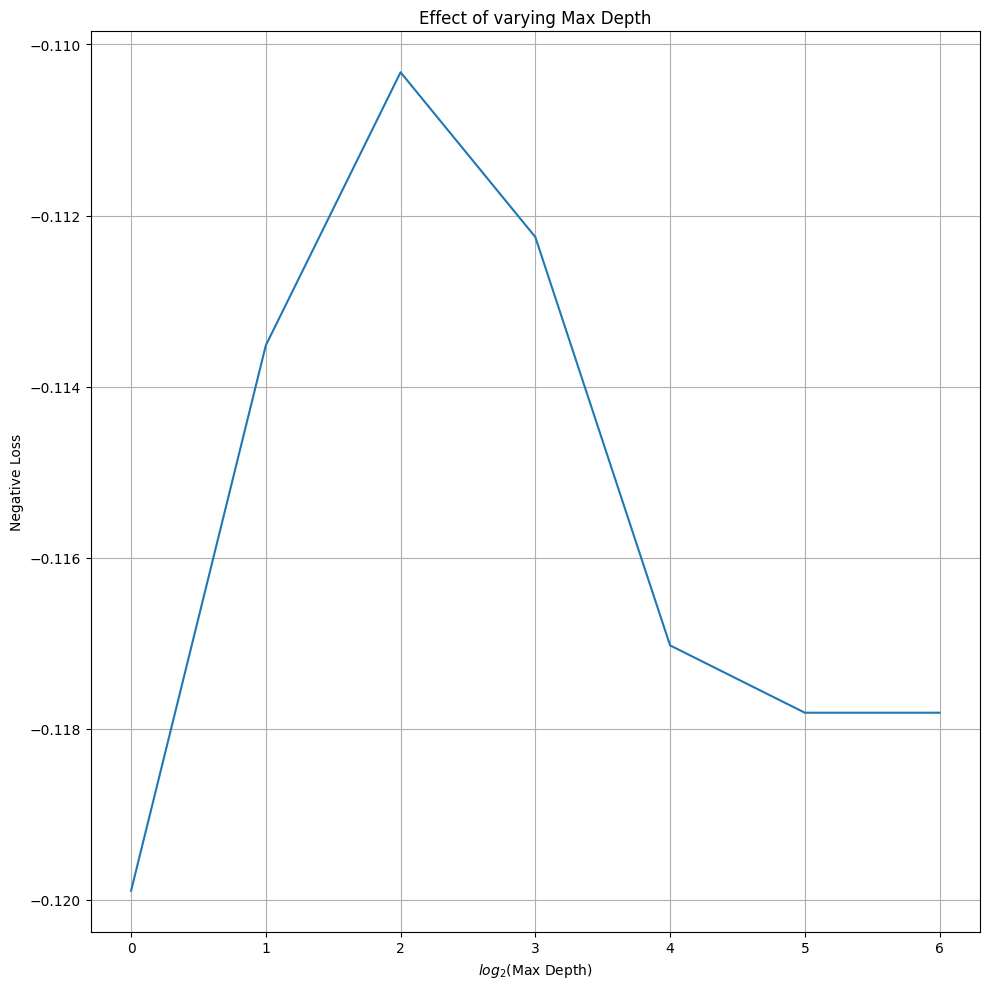

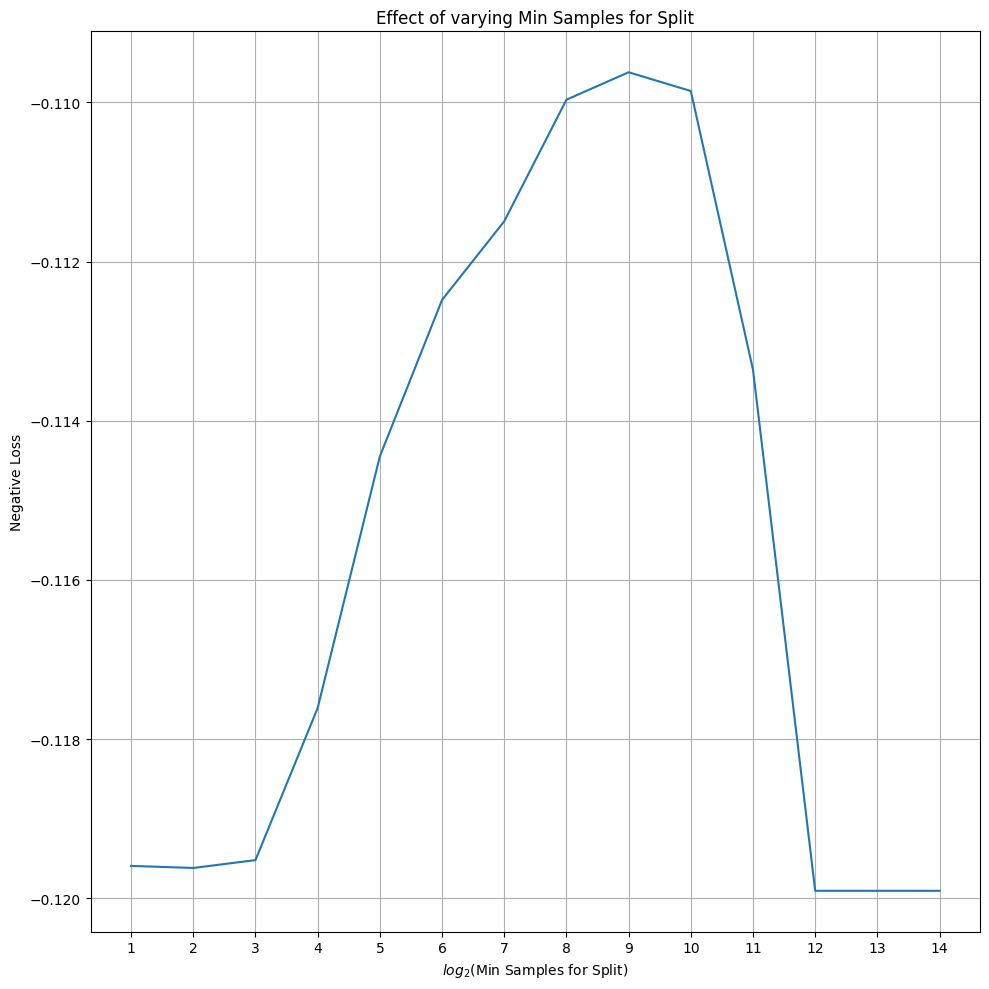

In [10]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_max_depth = GS.cv_results_['param_max_depth']
cv_min_samples_split = GS.cv_results_['param_min_samples_split']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_max_depth_DTR, hp_list_max_depth_exponents_DTR, cv_max_depth, "max_depth"), 
    (hp_list_min_samples_split_DTR, hp_list_min_samples_split_exponents_DTR, cv_min_samples_split, "min_samples_split")
]

params_evals_DTR = evaluate(GS, hyperparam_data, performances, "decision_tree_regressor", is_regression=True)

In [11]:
#Model 2 - Random Forest
from sklearn.ensemble import RandomForestRegressor

#Hyperparams - exponential grid-search
hp_list_n_estimators_exponents_RFR = [i for i in range(0,7)]
hp_list_n_estimators_RFR = [2**i for i in hp_list_n_estimators_exponents_RFR]

hp_list_max_depth_exponents_RFR = [i for i in range(0,4)]
hp_list_max_depth_RFR = [2**i for i in hp_list_max_depth_exponents_RFR]

hp_list_min_samples_split_exponents_RFR = [i for i in range(1, 4)]
hp_list_min_samples_split_RFR = [2**i for i in hp_list_min_samples_split_exponents_RFR]

params_inputs_RFR= {
    'n_estimators' : hp_list_n_estimators_RFR,
    'max_depth' : hp_list_max_depth_RFR,
    'min_samples_split' : hp_list_min_samples_split_RFR,
}

In [12]:
#Training (takes about 50 seconds)
RFR_model = RandomForestRegressor(random_state=0)
GS = GridSearchCV(RFR_model, params_inputs_RFR, scoring='neg_mean_absolute_percentage_error')
GS.fit(features_white.to_numpy(), target_white.to_numpy())

GridSearchCV(estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64]},
             scoring='neg_mean_absolute_percentage_error')

Best hyperparams overall:
{'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 64}
Best score with those hyperparams:
-0.10144523201012219


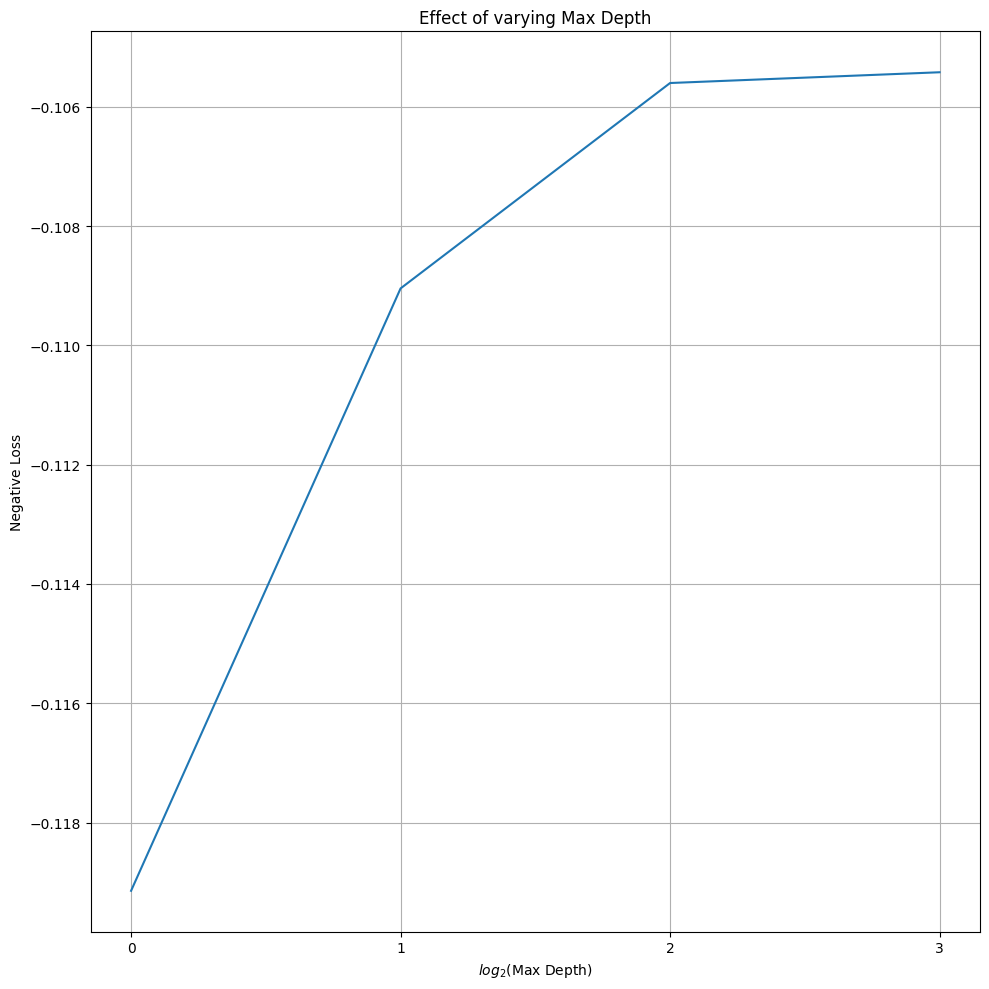

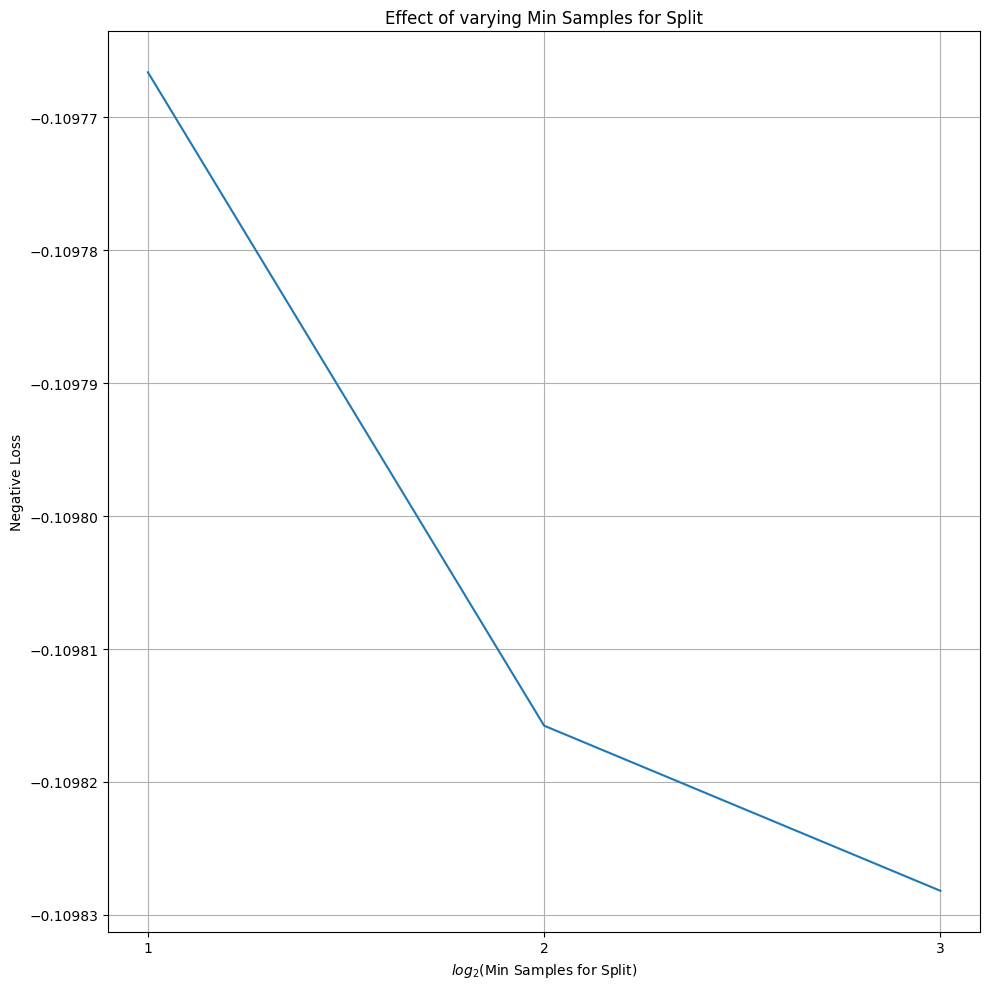

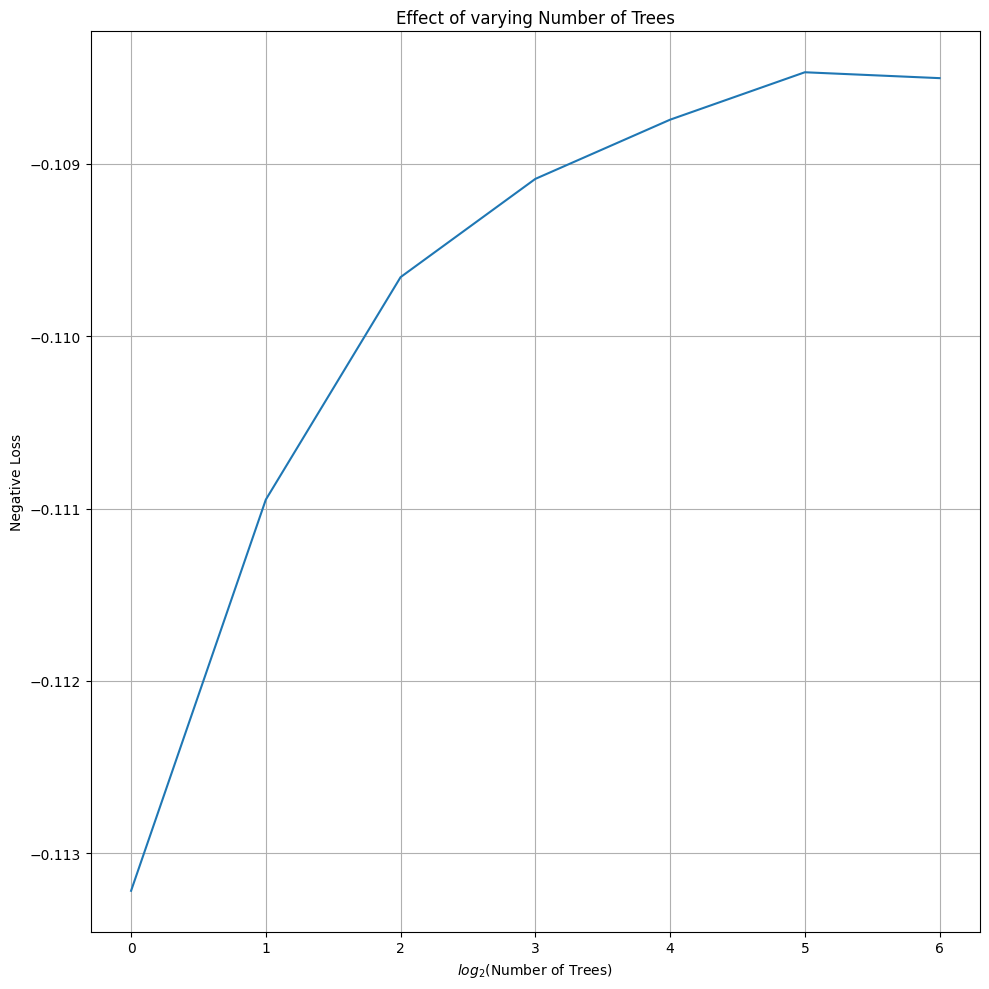

In [13]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_n_estimators = GS.cv_results_['param_n_estimators']
cv_max_depth = GS.cv_results_['param_max_depth']
cv_min_samples_split = GS.cv_results_['param_min_samples_split']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_max_depth_RFR, hp_list_max_depth_exponents_RFR, cv_max_depth, "max_depth"), 
    (hp_list_min_samples_split_RFR, hp_list_min_samples_split_exponents_RFR, cv_min_samples_split, "min_samples_split"),
    (hp_list_n_estimators_RFR, hp_list_n_estimators_exponents_RFR, cv_n_estimators, "n_estimators"),
]

params_evals_RFR = evaluate(GS, hyperparam_data, performances, "random_forest_regressor", is_regression=True)

In [14]:
#Part 2 - HPO for classification

In [15]:
#Model 1 - Support Vector Classifier
from sklearn.svm import SVC

#Hyperparams - exponential grid-search, also some categorical choices for hyperparams
hp_list_C_exponents_SVC = [i for i in range(0,15)]
hp_list_C_SVC = [2**i for i in hp_list_C_exponents_SVC]

hp_list_kernel_SVC = ['poly', 'rbf']

params_inputs_SVC = {
    'C': hp_list_C_SVC,
    'kernel' : hp_list_kernel_SVC,
}

In [16]:
#Training (takes about 60 seconds)
SVC_model = SVC(random_state=0)
GS = GridSearchCV(SVC_model, params_inputs_SVC, scoring='accuracy')
GS.fit(features_all.to_numpy(), target_all.to_numpy())

GridSearchCV(estimator=SVC(random_state=0),
             param_grid={'C': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024,
                               2048, 4096, 8192, 16384],
                         'kernel': ['poly', 'rbf']},
             scoring='accuracy')

Best hyperparams overall:
{'C': 16384, 'kernel': 'rbf'}
Best score with those hyperparams:
0.9881486350447088


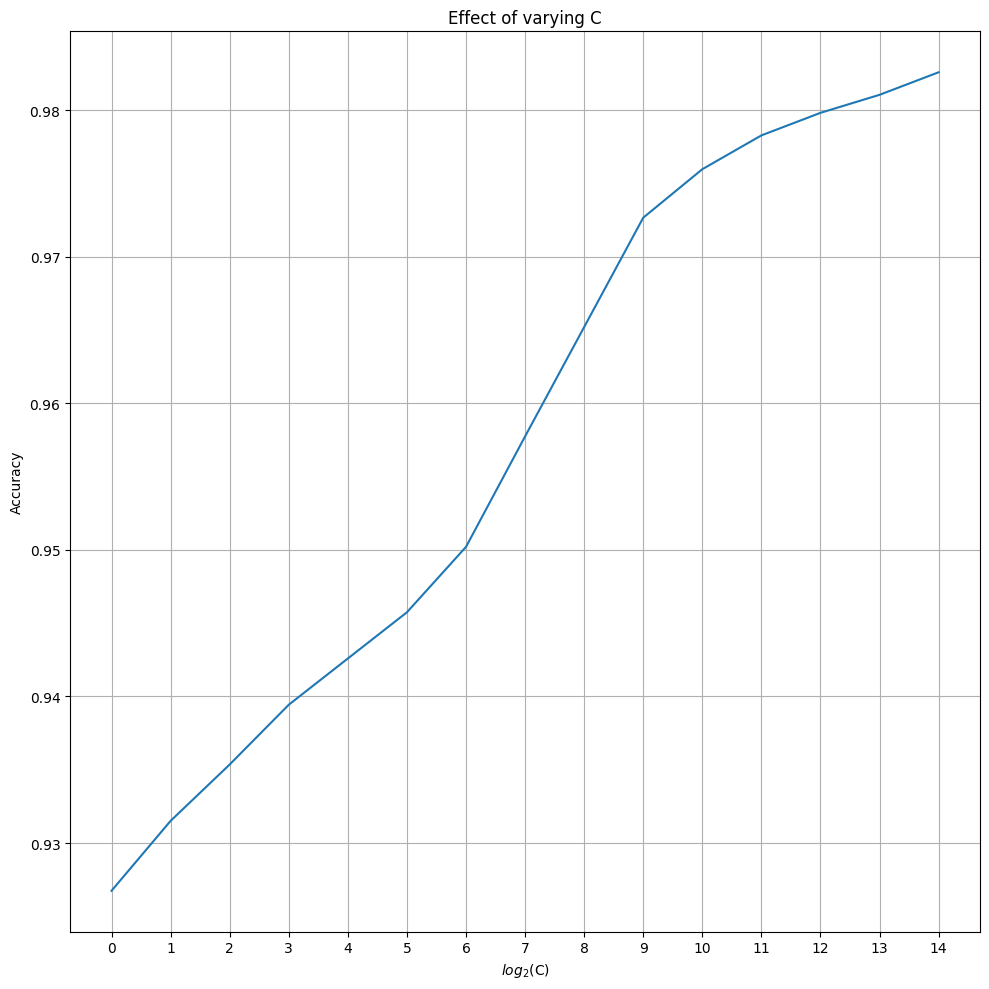

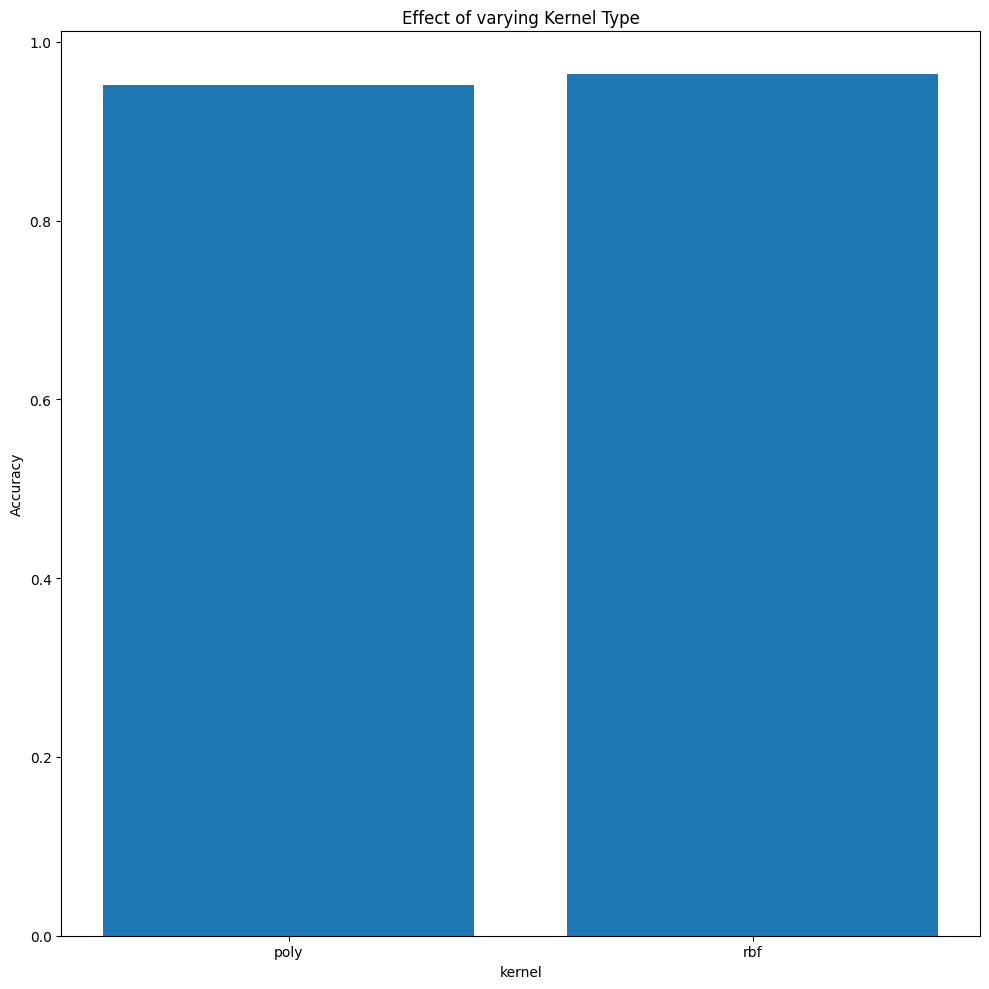

In [17]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_C = GS.cv_results_['param_C']
cv_kernel = GS.cv_results_['param_kernel']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_C_SVC, hp_list_C_exponents_SVC, cv_C, "C"),
    (hp_list_kernel_SVC, None, cv_kernel, "kernel"),
]

params_evals_SVC = evaluate(GS, hyperparam_data, performances, "SVC", is_regression=False)

In [18]:
#Model 2 - Logistic regression
from sklearn.linear_model import LogisticRegression

#Hyperparams - exponential grid-search, also some categorical choices for hyperparams
hp_list_C_exponents_log = [i for i in range(0,8)]
hp_list_C_log = [2**i for i in hp_list_C_exponents_log]

hp_list_penalty_log = ['l1', 'l2'] #Note that for these, not all solvers are compatible. liblinear is one that is compatible

params_inputs_log = {
    'C': hp_list_C_log,
    'penalty' : hp_list_penalty_log,
}

In [19]:
#Training (takes about 40 seconds)
log_reg_model = LogisticRegression(random_state=0, solver='liblinear')
GS = GridSearchCV(log_reg_model, params_inputs_log, scoring='accuracy')
GS.fit(features_all.to_numpy(), target_all.to_numpy())

GridSearchCV(estimator=LogisticRegression(random_state=0, solver='liblinear'),
             param_grid={'C': [1, 2, 4, 8, 16, 32, 64, 128],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

Best hyperparams overall:
{'C': 64, 'penalty': 'l2'}
Best score with those hyperparams:
0.9881488719133061


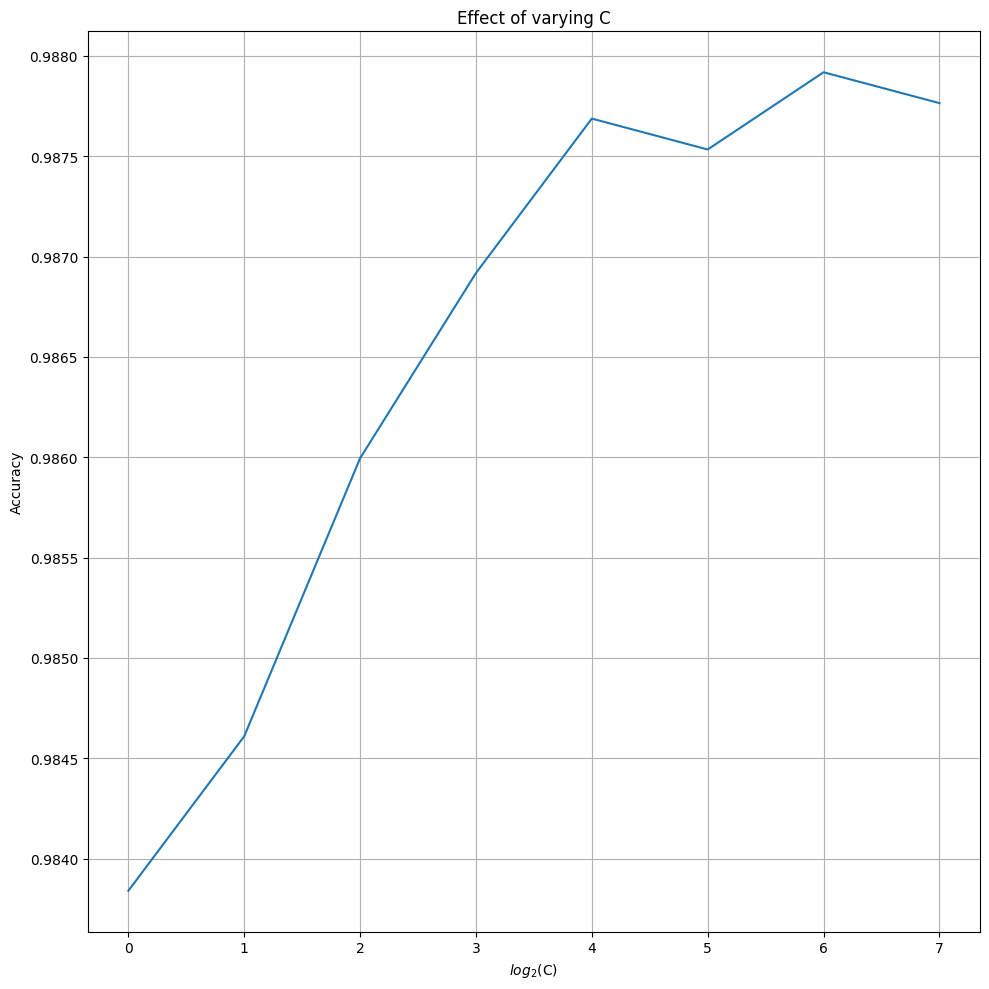

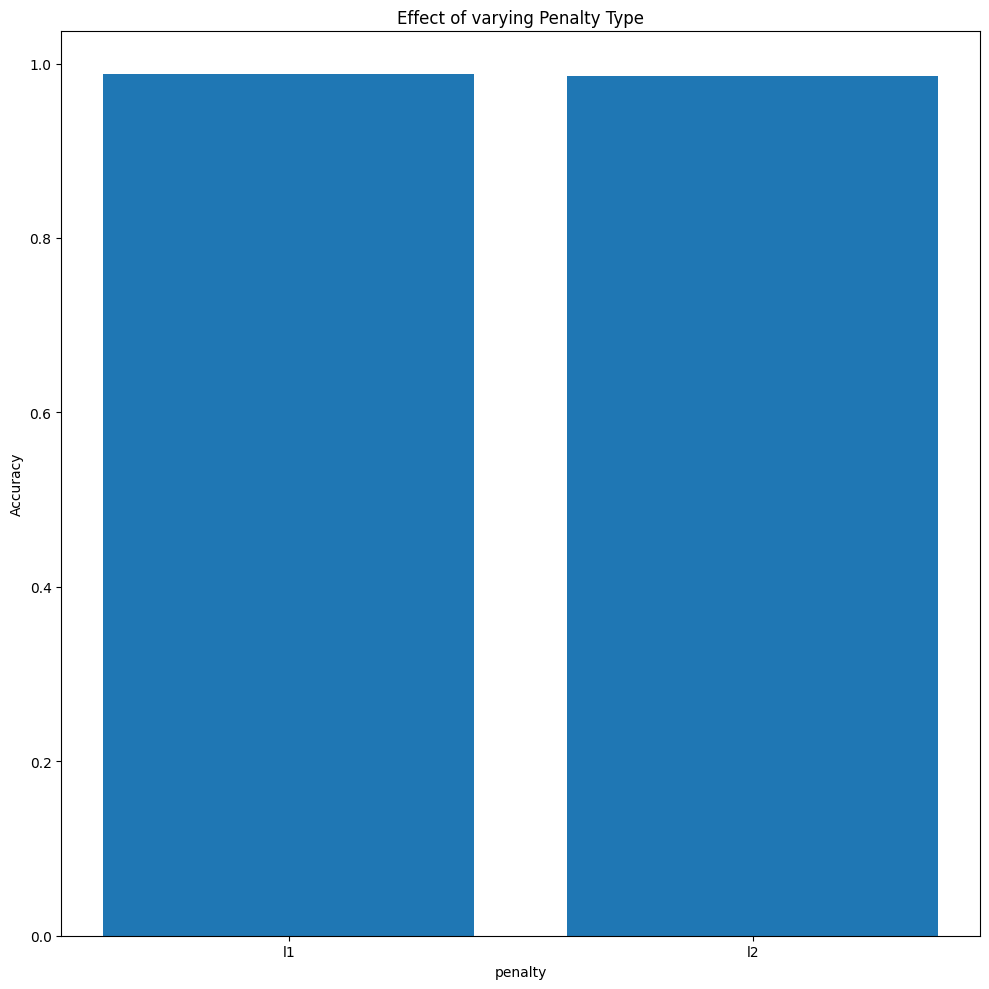

In [20]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_C = GS.cv_results_['param_C']
cv_penalty = GS.cv_results_['param_penalty']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_C_log, hp_list_C_exponents_log, cv_C, "C"),
    (hp_list_penalty_log, None, cv_penalty, "penalty"),
]

params_evals_log = evaluate(GS, hyperparam_data, performances, "logistic_regression", is_regression=False)

In [21]:
#Model 3 - Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

#Hyperparams - exponential grid-search - similar to DecisionTreeRegressor from before
hp_list_max_depth_exponents_DTC = [i for i in range(0,7)]
hp_list_max_depth_DTC = [2**i for i in hp_list_max_depth_exponents_DTC]

hp_list_min_samples_split_exponents_DTC = [i for i in range(1, 15)]
hp_list_min_samples_split_DTC = [2**i for i in hp_list_min_samples_split_exponents_DTC]

params_inputs_DTC = {
    'max_depth' : hp_list_max_depth_DTC,
    'min_samples_split' : hp_list_min_samples_split_DTC,
}

In [22]:
#Training (takes about 8 seconds)
DTC = DecisionTreeClassifier(random_state=0)
GS = GridSearchCV(DTC, params_inputs_DTC, scoring='accuracy')
GS.fit(features_all.to_numpy(), target_all.to_numpy())

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [1, 2, 4, 8, 16, 32, 64],
                         'min_samples_split': [2, 4, 8, 16, 32, 64, 128, 256,
                                               512, 1024, 2048, 4096, 8192,
                                               16384]},
             scoring='accuracy')

Best hyperparams overall:
{'max_depth': 32, 'min_samples_split': 2}
Best score with those hyperparams:
0.9810676852016345


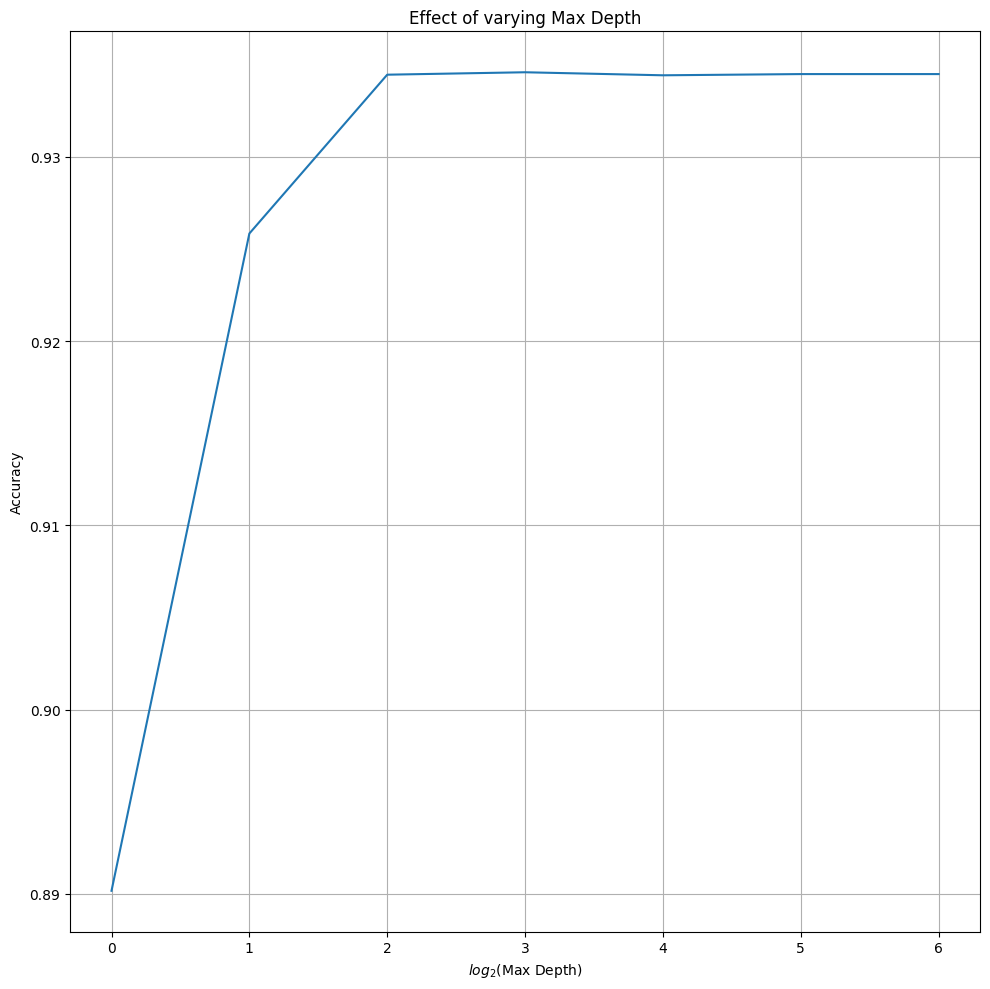

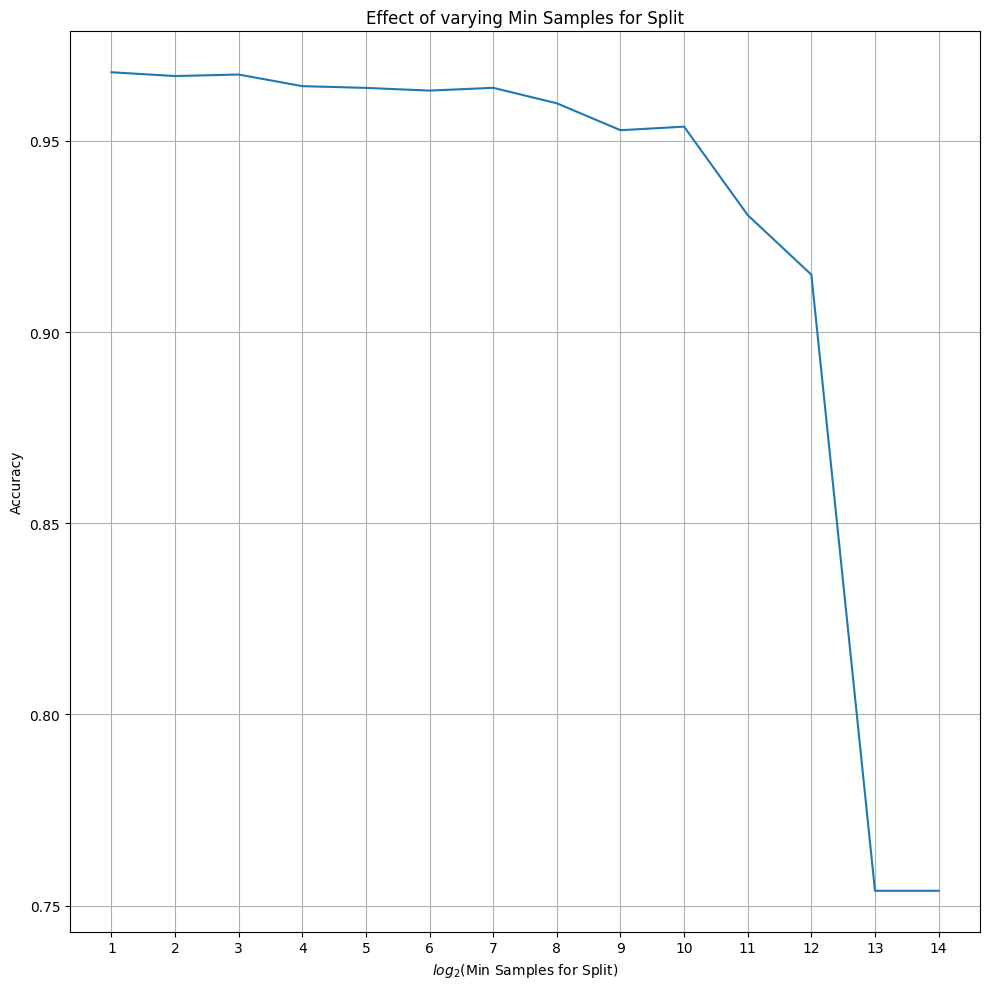

In [23]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_max_depth = GS.cv_results_['param_max_depth']
cv_min_samples_split = GS.cv_results_['param_min_samples_split']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_max_depth_DTC, hp_list_max_depth_exponents_DTC, cv_max_depth, "max_depth"),
    (hp_list_min_samples_split_DTC, hp_list_min_samples_split_exponents_DTC, cv_min_samples_split, "min_samples_split"),
]

params_evals_DTC = evaluate(GS, hyperparam_data, performances, "decision_tree_classifier", is_regression=False)

In [24]:
#Model 4 - K-nearest neighbor
from sklearn.neighbors import KNeighborsClassifier

#Hyperparams - exponential grid-search
hp_list_n_neighbors_exponents_KNN = [i for i in range(0,7)]
hp_list_n_neighbors_KNN = [2**i for i in hp_list_n_neighbors_exponents_KNN]

hp_list_metric_KNN = ['l1', 'l2']

params_inputs_KNN = {
    'n_neighbors' : hp_list_n_neighbors_KNN,
    'metric' : hp_list_metric_KNN,
}

In [25]:
#Training (takes about 2 seconds)
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, params_inputs_KNN, scoring='accuracy')
GS.fit(features_all.to_numpy(), target_all.to_numpy())

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['l1', 'l2'],
                         'n_neighbors': [1, 2, 4, 8, 16, 32, 64]},
             scoring='accuracy')

Best hyperparams overall:
{'metric': 'l1', 'n_neighbors': 8}
Best score with those hyperparams:
0.9458242435009179


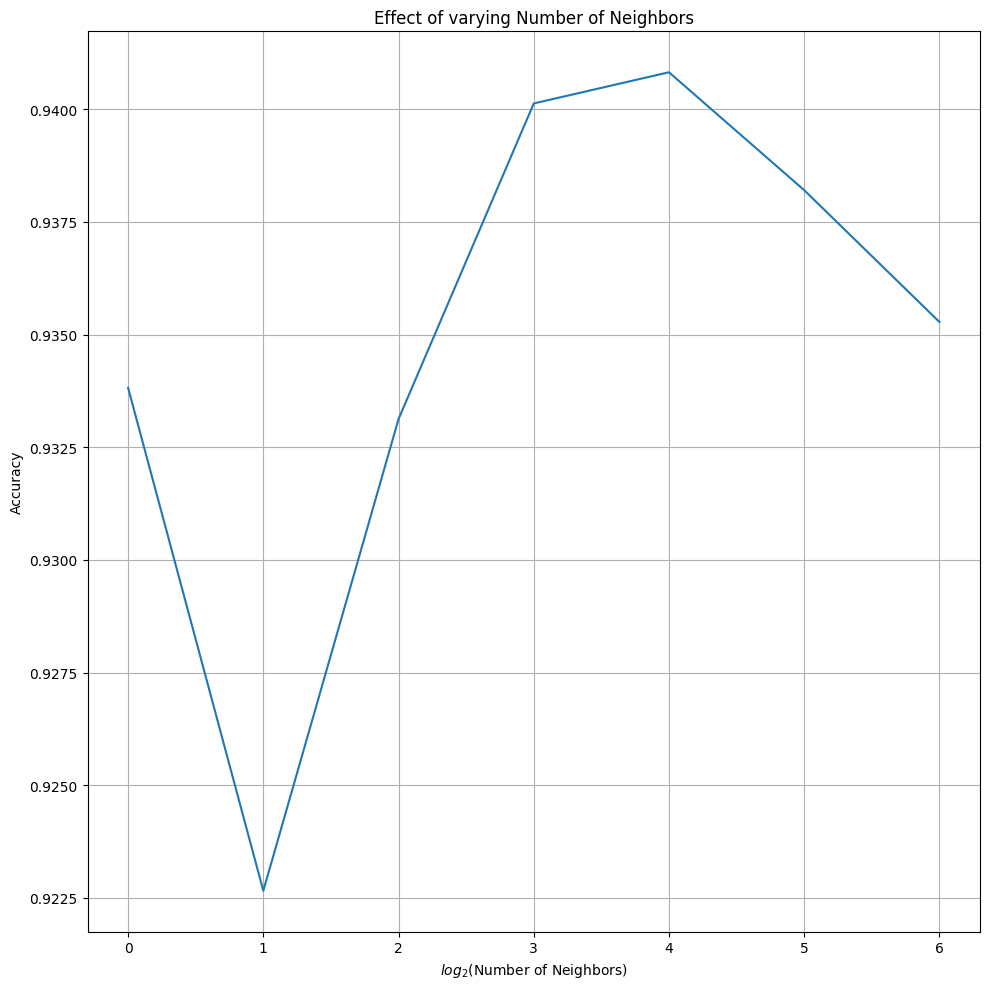

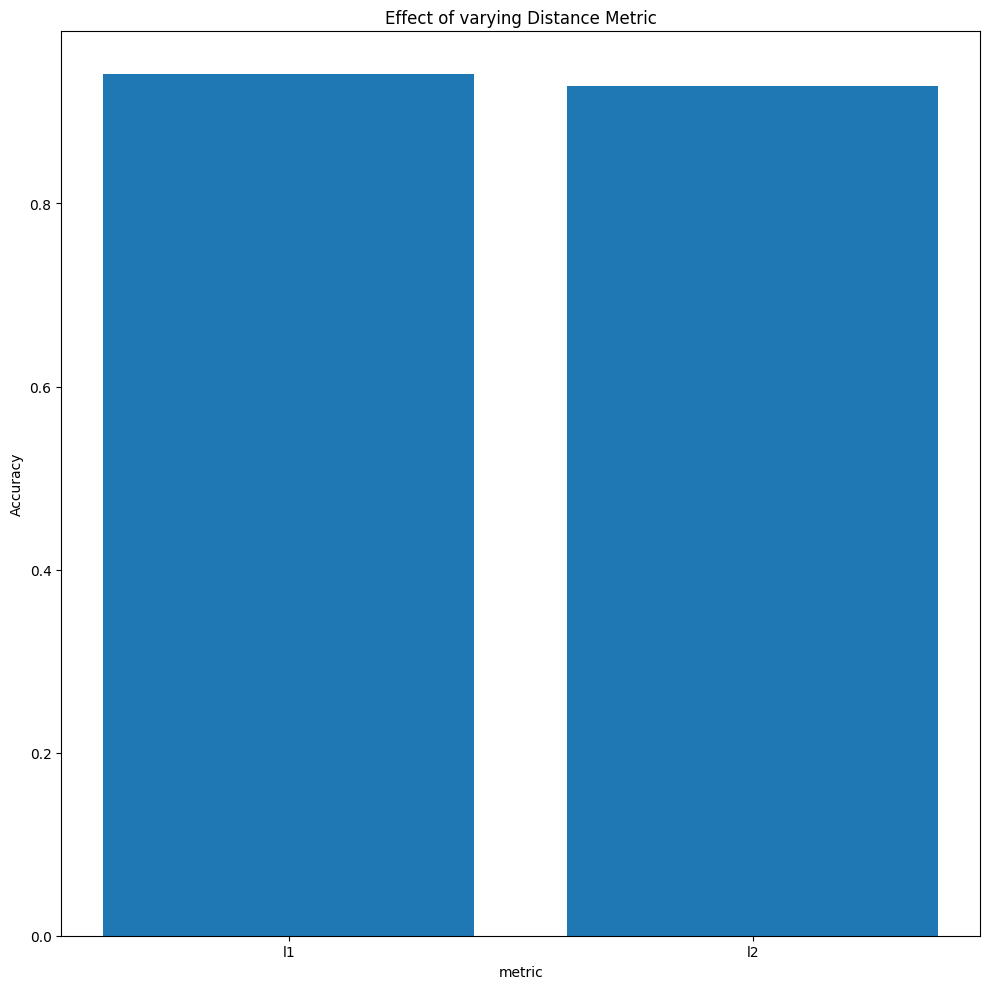

In [26]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_n_neighbors = GS.cv_results_['param_n_neighbors']
cv_metric = GS.cv_results_['param_metric']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_n_neighbors_KNN, hp_list_n_neighbors_exponents_KNN, cv_n_neighbors, "n_neighbors"),
    (hp_list_metric_KNN, None, cv_metric, "metric"),
]

params_evals_KNN = evaluate(GS, hyperparam_data, performances, "KNN", is_regression=False)

In [27]:
#Naive Bayes is often considered to have no hyperparams so it will be skipped

In [28]:
#Model 5 - Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

#Hyperparams - exponential grid-search - similar to the RandomForestRegressor from before
hp_list_n_estimators_exponents_RFC = [i for i in range(0,7)]
hp_list_n_estimators_RFC = [2**i for i in hp_list_n_estimators_exponents_RFC]

hp_list_max_depth_exponents_RFC = [i for i in range(0,4)]
hp_list_max_depth_RFC = [2**i for i in hp_list_max_depth_exponents_RFC]

hp_list_min_samples_split_exponents_RFC = [i for i in range(1, 4)]
hp_list_min_samples_split_RFC = [2**i for i in hp_list_min_samples_split_exponents_RFC]

params_inputs_RFC = {
    'n_estimators' : hp_list_n_estimators_RFC,
    'max_depth' : hp_list_max_depth_RFC,
    'min_samples_split' : hp_list_min_samples_split_RFC,
}

In [29]:
#Training (takes about 50 seconds)
RFC_model = RandomForestClassifier(random_state=0)
GS = GridSearchCV(RFC_model, params_inputs_RFC, scoring='accuracy')
GS.fit(features_all.to_numpy(), target_all.to_numpy())

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64]},
             scoring='accuracy')

Best hyperparams overall:
{'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 32}
Best score with those hyperparams:
0.9933809439213596


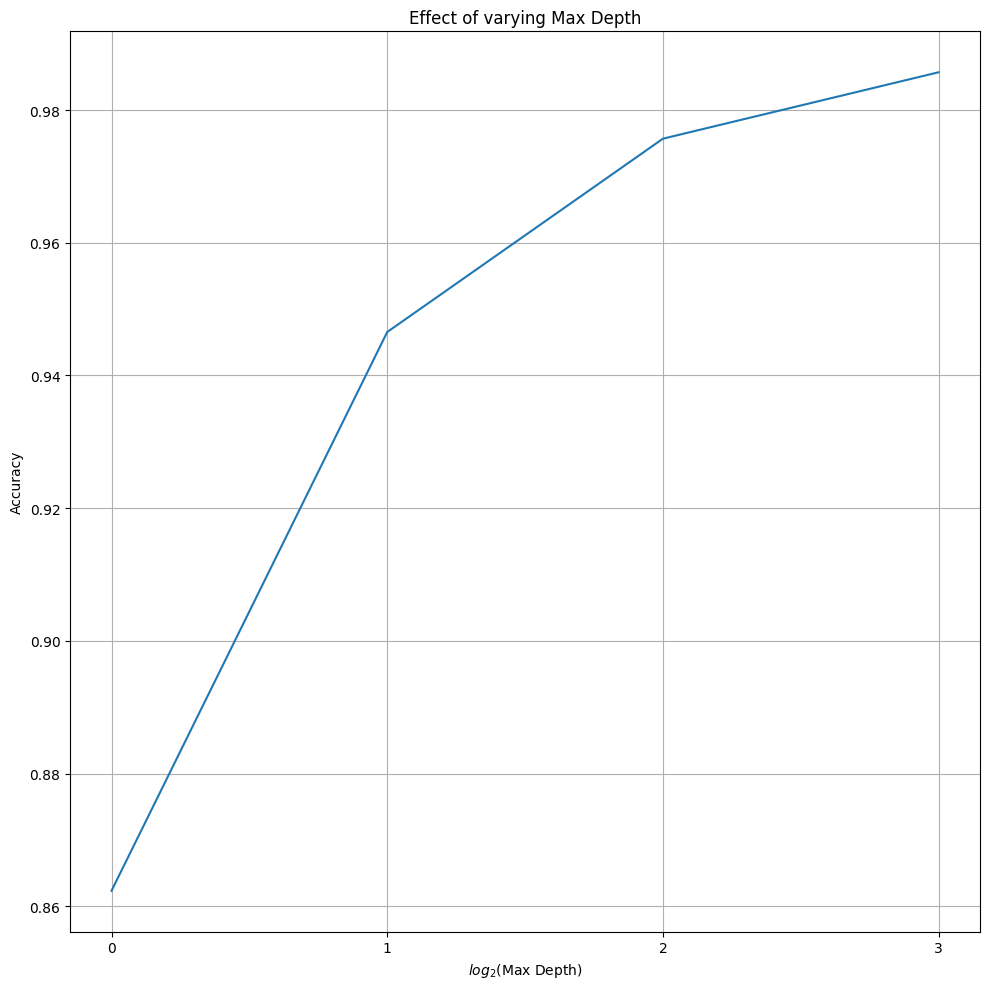

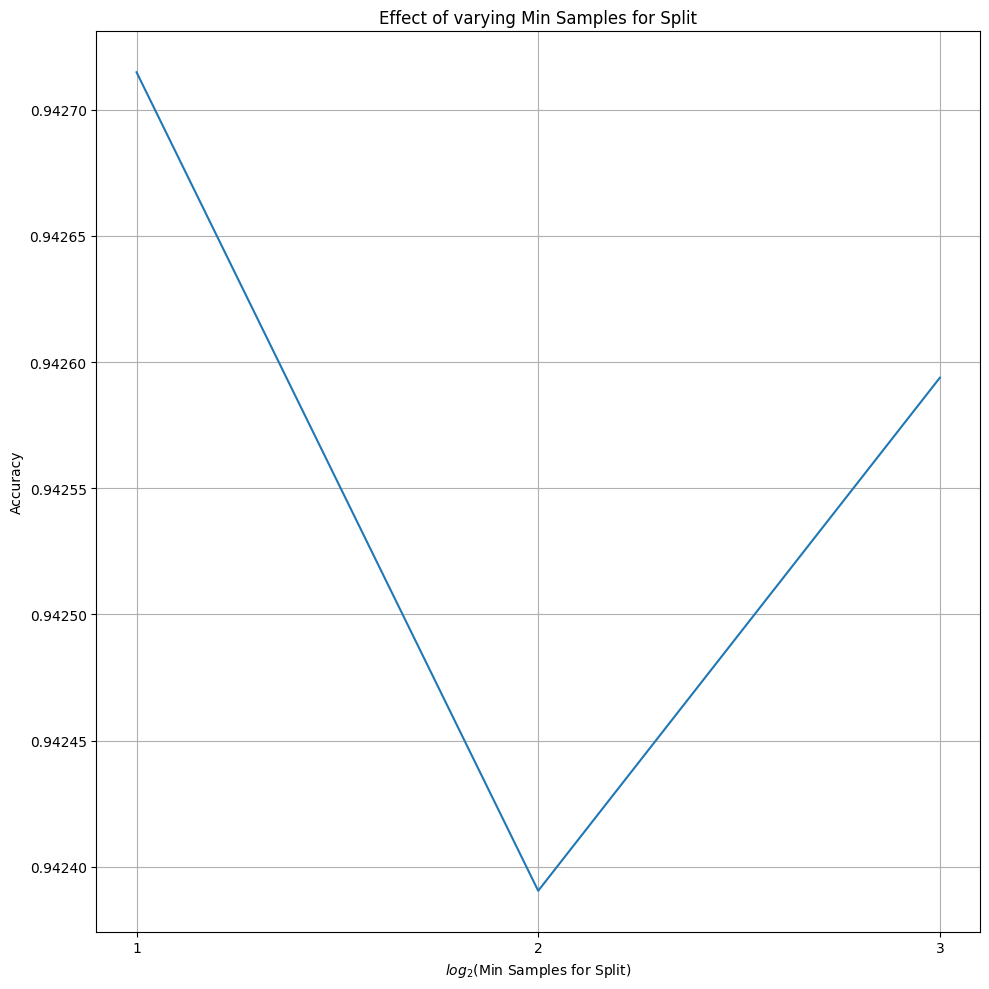

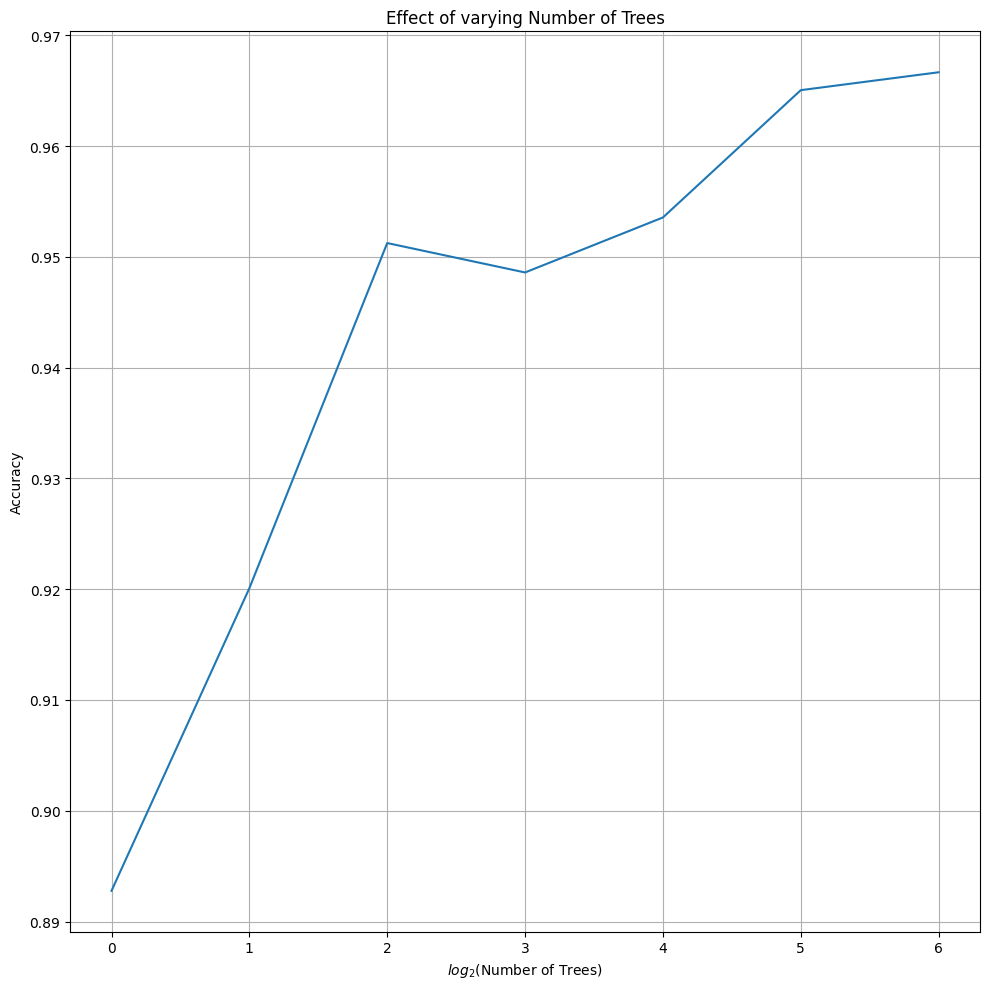

In [30]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_n_estimators = GS.cv_results_['param_n_estimators']
cv_max_depth = GS.cv_results_['param_max_depth']
cv_min_samples_split = GS.cv_results_['param_min_samples_split']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_max_depth_RFC, hp_list_max_depth_exponents_RFC, cv_max_depth, "max_depth"), 
    (hp_list_min_samples_split_RFC, hp_list_min_samples_split_exponents_RFC, cv_min_samples_split, "min_samples_split"),
    (hp_list_n_estimators_RFC, hp_list_n_estimators_exponents_RFC, cv_n_estimators, "n_estimators"),
]

params_evals_RFC = evaluate(GS, hyperparam_data, performances, "random_forest_classifier", is_regression=False)

In [31]:
#Graphs that contain multiple models in the same graph
file_path = "graphs/combos/"

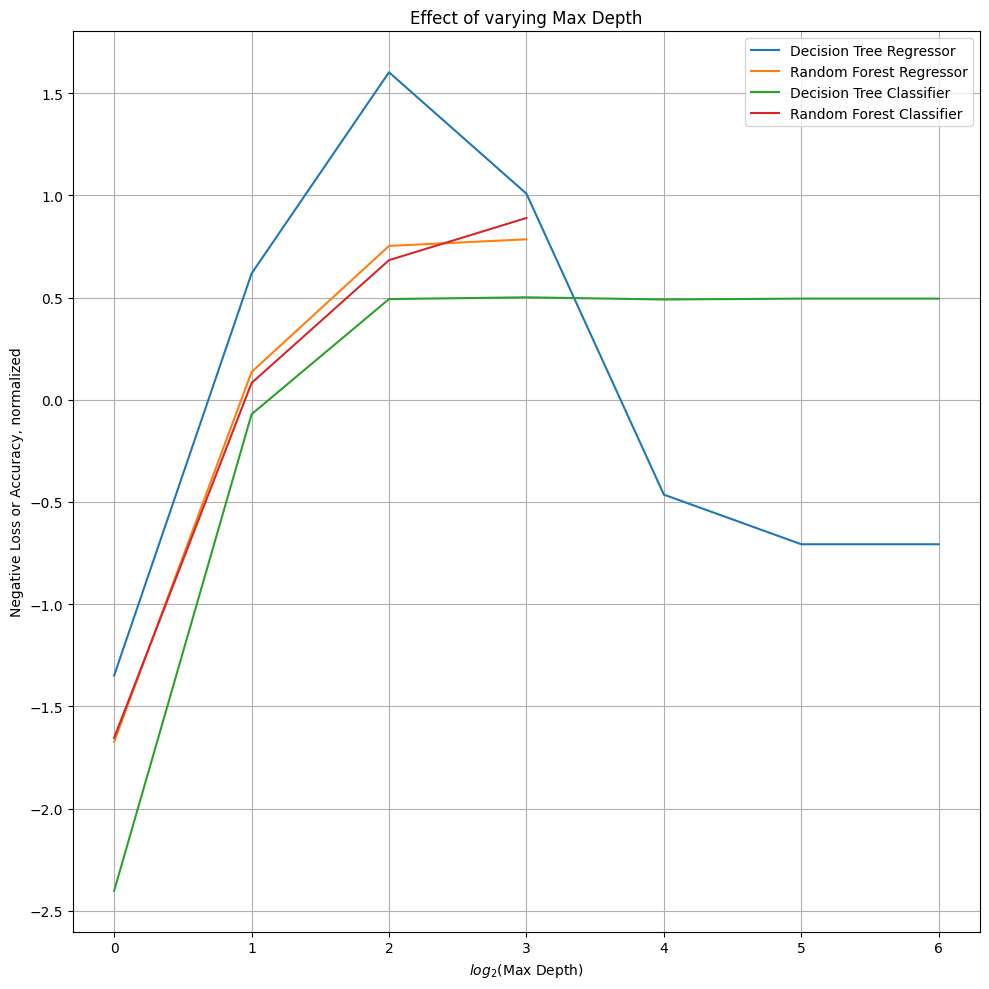

In [32]:
hyperparam = "max_depth"
plt.figure(figsize=(10,10))
plt.plot(hp_list_max_depth_exponents_DTR, stats.zscore(params_evals_DTR[hyperparam]), label='Decision Tree Regressor')
plt.plot(hp_list_max_depth_exponents_RFR, stats.zscore(params_evals_RFR[hyperparam]), label='Random Forest Regressor')
plt.plot(hp_list_max_depth_exponents_DTC, stats.zscore(params_evals_DTC[hyperparam]), label='Decision Tree Classifier')
plt.plot(hp_list_max_depth_exponents_RFC, stats.zscore(params_evals_RFC[hyperparam]), label='Random Forest Classifier')
plt.grid(True)
plt.title("Effect of varying " + hp_decoder[hyperparam])
plt.xlabel("$log_2$(" + hp_decoder[hyperparam] + ")")
plt.ylabel("Negative Loss or Accuracy, normalized")
plt.legend()
plt.tight_layout()
plt.savefig(file_path + "combo_" + hyperparam)

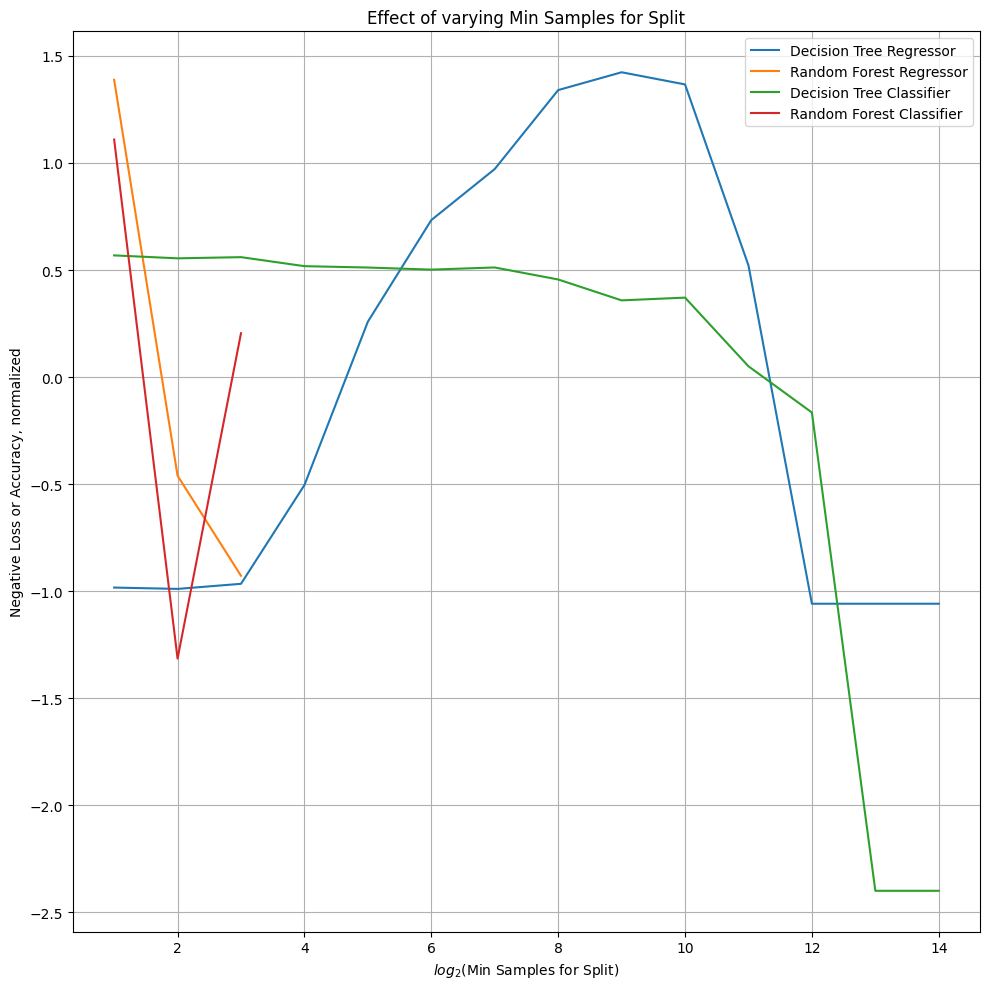

In [33]:
hyperparam = "min_samples_split"
plt.figure(figsize=(10,10))
plt.plot(hp_list_min_samples_split_exponents_DTR, stats.zscore(params_evals_DTR[hyperparam]), label='Decision Tree Regressor')
plt.plot(hp_list_min_samples_split_exponents_RFR, stats.zscore(params_evals_RFR[hyperparam]), label='Random Forest Regressor')
plt.plot(hp_list_min_samples_split_exponents_DTC, stats.zscore(params_evals_DTC[hyperparam]), label='Decision Tree Classifier')
plt.plot(hp_list_min_samples_split_exponents_RFC, stats.zscore(params_evals_RFC[hyperparam]), label='Random Forest Classifier')
plt.grid(True)
plt.title("Effect of varying " + hp_decoder[hyperparam])
plt.xlabel("$log_2$(" + hp_decoder[hyperparam] + ")")
plt.ylabel("Negative Loss or Accuracy, normalized")
plt.legend()
plt.tight_layout()
plt.savefig(file_path + "combo_" + hyperparam)

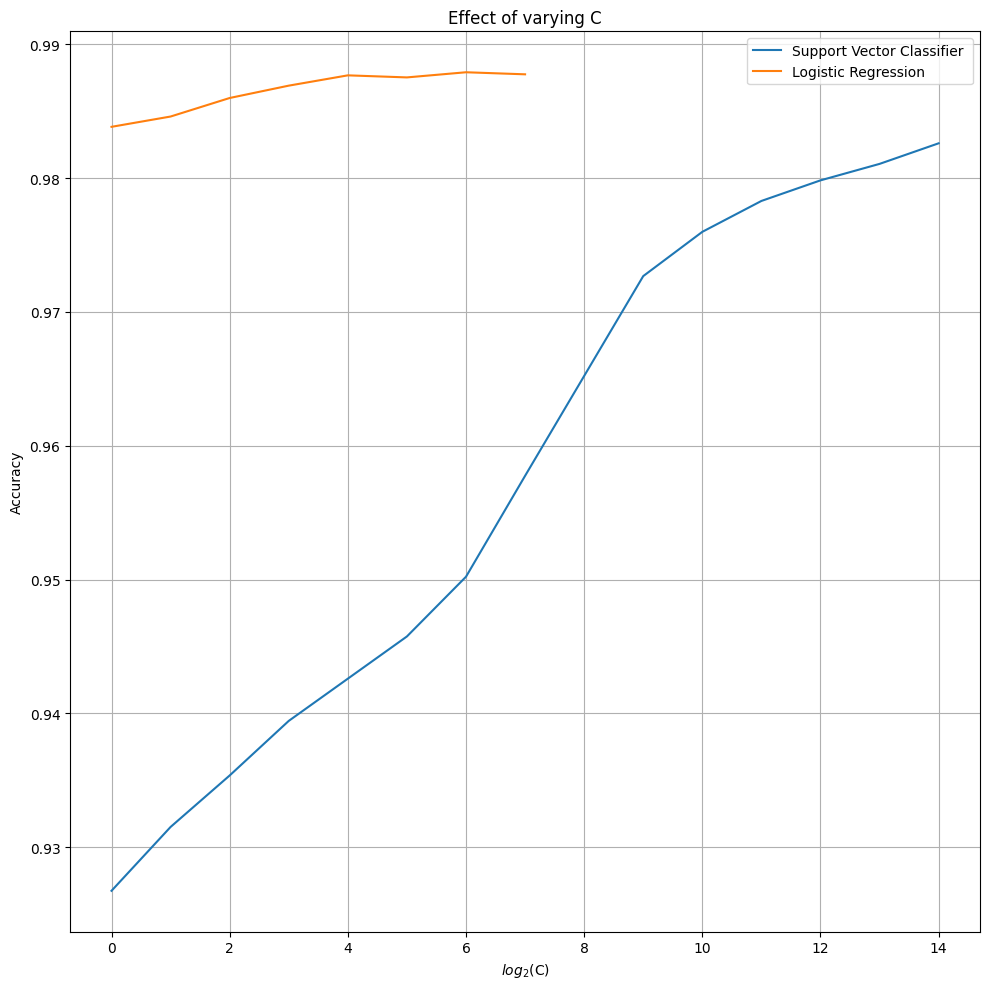

In [34]:
hyperparam = "C"
plt.figure(figsize=(10,10))
plt.plot(hp_list_C_exponents_SVC, params_evals_SVC[hyperparam], label='Support Vector Classifier ')
plt.plot(hp_list_C_exponents_log, params_evals_log[hyperparam], label='Logistic Regression')
plt.grid(True)
plt.title("Effect of varying " + hp_decoder[hyperparam])
plt.xlabel("$log_2$(" + hp_decoder[hyperparam] + ")")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig(file_path + "combo_" + hyperparam)

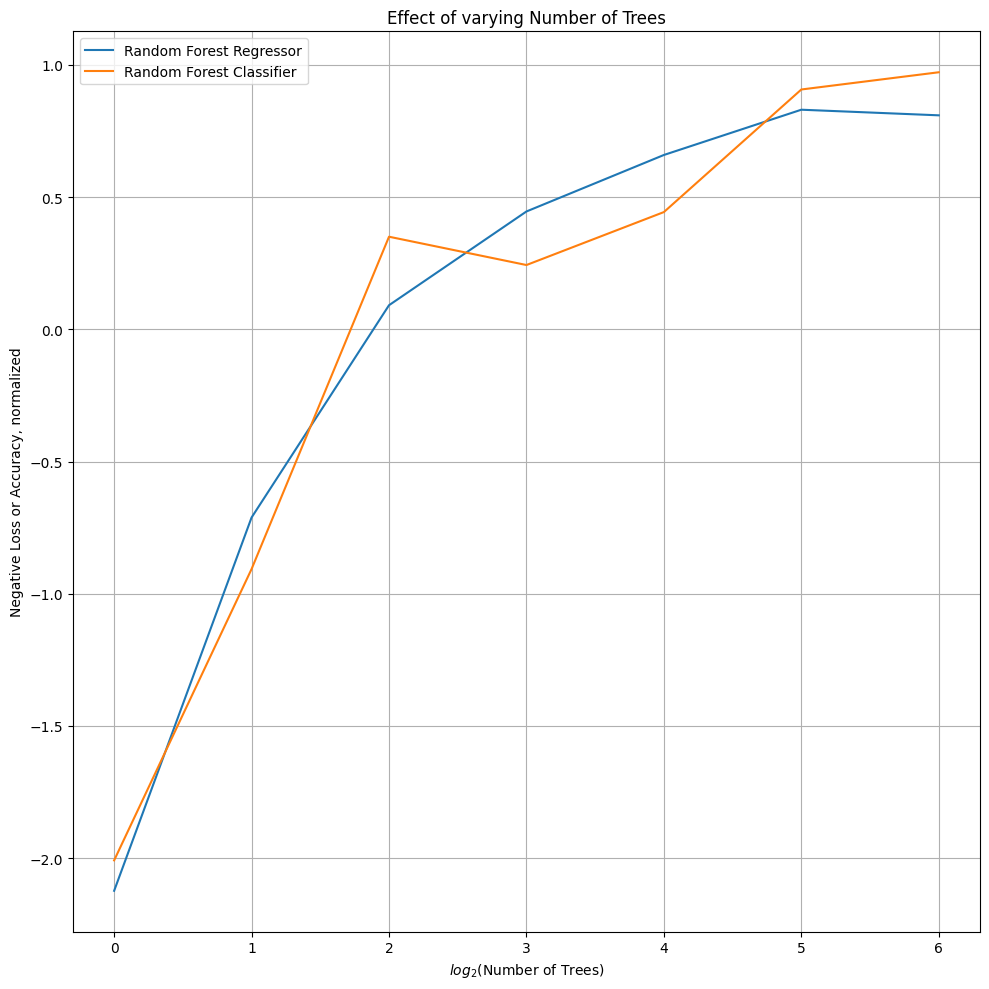

In [35]:
hyperparam = "n_estimators"
plt.figure(figsize=(10,10))
plt.plot(hp_list_n_estimators_exponents_RFR, stats.zscore(params_evals_RFR[hyperparam]), label='Random Forest Regressor')
plt.plot(hp_list_n_estimators_exponents_RFC, stats.zscore(params_evals_RFC[hyperparam]), label='Random Forest Classifier')
plt.grid(True)
plt.title("Effect of varying " + hp_decoder[hyperparam])
plt.xlabel("$log_2$(" + hp_decoder[hyperparam] + ")")
plt.ylabel("Negative Loss or Accuracy, normalized")
plt.legend()
plt.tight_layout()
plt.savefig(file_path + "combo_" + hyperparam)

In [50]:
#Bayesian optimization - values to compare to grid-search
from sklearn.model_selection import cross_val_score, KFold #Allows a setup of nested resampling

In [56]:
#Create evaluation function for Bayesian optimization
def evaluate_bo(BS, is_regression=True):
    """evaluate bayesian optimization with nested resampling as the performance estimate"""
    outer_cv = KFold(n_splits = 3, shuffle=True, random_state=0)
    if is_regression:
        outer_scores = cross_val_score(BS, features_white.to_numpy(), target_white.to_numpy(), cv=outer_cv)
    else:
        outer_scores = cross_val_score(BS, features_all.to_numpy(), target_all.to_numpy(), cv=outer_cv)
    print("Best hyperparams overall:")
    for pair in BS.best_params_:
        print(pair + ": " + str(BS.best_params_[pair]))
    print("\nAverage score from nested resampling:")
    print(outer_scores.mean())

In [53]:
#Decision Tree Regressor (1m48s)
DTR_model = DecisionTreeRegressor(random_state=0)
BS = BayesSearchCV(DTR_model,
    {
        'max_depth' : Integer(min(hp_list_max_depth_DTR), max(hp_list_max_depth_DTR)),
        'min_samples_split' : Integer(min(hp_list_min_samples_split_DTR), max(hp_list_min_samples_split_DTR)),
    },
    scoring='neg_mean_absolute_percentage_error',
    random_state=0)
BS.fit(features_white.to_numpy(), target_white.to_numpy())

evaluate_bo(BS)

C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best hyperparams overall:
max_depth: 44
min_samples_split: 582

Average score from nested resampling:
-0.10347216465613691


In [54]:
#Random Forest Regressor (6m)
RFR_model = RandomForestRegressor(random_state=0)
BS = BayesSearchCV(RFR_model,
    {
        'max_depth' : Integer(min(hp_list_max_depth_RFR), max(hp_list_max_depth_RFR)),
        'min_samples_split' : Integer(min(hp_list_min_samples_split_RFR), max(hp_list_min_samples_split_RFR)),
        'n_estimators' : Integer(min(hp_list_n_estimators_RFR), max(hp_list_n_estimators_RFR)),
    },
    scoring='neg_mean_absolute_percentage_error',
    random_state=0)
BS.fit(features_white.to_numpy(), target_white.to_numpy())

evaluate_bo(BS)

Best hyperparams overall:
max_depth: 8
min_samples_split: 8
n_estimators: 58

Average score from nested resampling:
-0.09461240336207581


In [57]:
#Support Vector Classifier (1m23s)
SVC_model = SVC(random_state=0)
BS = BayesSearchCV(SVC_model,
    {
        'C' : Integer(min(hp_list_C_SVC), max(hp_list_C_SVC)),
        'kernel' : Categorical(hp_list_kernel_SVC),
    },
    scoring='accuracy',
    random_state=0,
    n_iter=10) #speeds up runtime
BS.fit(features_all.to_numpy(), target_all.to_numpy())

evaluate_bo(BS, is_regression=False)

Best hyperparams overall:
C: 15846
kernel: rbf

Average score from nested resampling:
0.988763783775715


In [59]:
#Logistic Regression (2m40s)
log_model = LogisticRegression(random_state=0, solver='liblinear')
BS = BayesSearchCV(log_model,
    {
        'C' : Integer(min(hp_list_C_log), max(hp_list_C_log)),
        'penalty' : Categorical(hp_list_penalty_log),
    },
    scoring='accuracy',
    random_state=0,)
BS.fit(features_all.to_numpy(), target_all.to_numpy())

evaluate_bo(BS, is_regression=False)

C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been eval

Best hyperparams overall:
C: 81
penalty: l2

Average score from nested resampling:
0.9878401384117478


In [60]:
#K-nearest-neighbor (about 2m15s)
KNN_model = KNeighborsClassifier()
BS = BayesSearchCV(KNN_model,
    {
        'n_neighbors' : Integer(min(hp_list_n_neighbors_KNN), max(hp_list_n_neighbors_KNN)),
        'metric' : Categorical(hp_list_metric_KNN),
    },
    scoring='accuracy',
    random_state=0,)
BS.fit(features_all.to_numpy(), target_all.to_numpy())

evaluate_bo(BS, is_regression=False)

C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been eval

Best hyperparams overall:
metric: l1
n_neighbors: 10

Average score from nested resampling:
0.9487457856992062


In [61]:
#Decision Tree Classifier (about 1m54s)
DTC_model = DecisionTreeClassifier(random_state=0)
BS = BayesSearchCV(DTC_model,
    {
        'max_depth' : Integer(min(hp_list_max_depth_DTC), max(hp_list_max_depth_DTC)),
        'min_samples_split' : Integer(min(hp_list_min_samples_split_DTC), max(hp_list_min_samples_split_DTC)),
    },
    scoring='accuracy',
    random_state=0,)
BS.fit(features_all.to_numpy(), target_all.to_numpy())

evaluate_bo(BS, is_regression=False)

C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been eval

Best hyperparams overall:
max_depth: 58
min_samples_split: 2

Average score from nested resampling:
0.9830699373123867


In [62]:
#Random Forest Classifier (about 3m55s)
RFC_model = RandomForestClassifier(random_state=0)
BS = BayesSearchCV(RFC_model,
    {
        'max_depth' : Integer(min(hp_list_max_depth_RFC), max(hp_list_max_depth_RFC)),
        'min_samples_split' : Integer(min(hp_list_min_samples_split_RFC), max(hp_list_min_samples_split_RFC)),
        'n_estimators' : Integer(min(hp_list_n_estimators_RFC), max(hp_list_n_estimators_RFC)),
    },
    scoring='accuracy',
    random_state=0)
BS.fit(features_all.to_numpy(), target_all.to_numpy())

evaluate_bo(BS, is_regression=False)

C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been eval

Best hyperparams overall:
max_depth: 8
min_samples_split: 8
n_estimators: 54

Average score from nested resampling:
0.9936895132771356
